# Stroke Prediction 

### Importing Libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [20]:
data = pd.read_csv("stroke-dataset.csv")
dataframe = data.copy()
dataframe.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Exploratory Data Analysis

In [21]:
dataframe.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [22]:
dataframe.shape
    

(5110, 12)

In [23]:
dataframe.describe()


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## Data Preprocessing

In [24]:
dataframe.isnull().sum()


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [25]:
dataframe = dataframe.dropna()

In [26]:
dataframe = dataframe.drop(['id'], axis=1)
dataframe.shape

(4909, 11)

In [27]:
print(dataframe["gender"].unique())
print(dataframe["hypertension"].unique())
print(dataframe["heart_disease"].unique())
print(dataframe["ever_married"].unique())
print(dataframe["work_type"].unique())
print(dataframe["Residence_type"].unique())
print(dataframe["smoking_status"].unique())

['Male' 'Female' 'Other']
[0 1]
[1 0]
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [28]:
le = LabelEncoder()

cat_columns = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
for cat_column in cat_columns:
    dataframe[cat_column] = le.fit_transform(dataframe[cat_column])
    
print(dataframe.shape)
dataframe.head()

(4909, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
2,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,0,79.0,1,0,1,3,0,174.12,24.0,2,1
5,1,81.0,0,0,1,2,1,186.21,29.0,1,1


In [29]:
print(dataframe["gender"].unique())
print(dataframe["hypertension"].unique())
print(dataframe["heart_disease"].unique())
print(dataframe["ever_married"].unique())
print(dataframe["work_type"].unique())
print(dataframe["Residence_type"].unique())
print(dataframe["smoking_status"].unique())

[1 0 2]
[0 1]
[1 0]
[1 0]
[2 3 0 4 1]
[1 0]
[1 2 3 0]


In [30]:

dataframe['bmi'].fillna(0, inplace=True)

In [31]:
dataframe.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
2,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,0,79.0,1,0,1,3,0,174.12,24.0,2,1
5,1,81.0,0,0,1,2,1,186.21,29.0,1,1


In [32]:
print(dataframe.columns)

dataframe.info()

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4909 non-null   int32  
 1   age                4909 non-null   float64
 2   hypertension       4909 non-null   int64  
 3   heart_disease      4909 non-null   int64  
 4   ever_married       4909 non-null   int32  
 5   work_type          4909 non-null   int32  
 6   Residence_type     4909 non-null   int32  
 7   avg_glucose_level  4909 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     4909 non-null   int32  
 10  stroke             4909 non-null   int64  
dtypes: float64(3), int32(5), int64(3)
memory usage: 364.3 KB


# Modeling

In [33]:
y = dataframe["stroke"]
X = dataframe.drop(["stroke"], axis=1)

In [34]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()
x_smote,y_smote=smote.fit_resample(X,y)

In [35]:
x_train_resampled,X_test, y_train_resampled,y_test=train_test_split(x_smote,y_smote,test_size=0.2,random_state=42)

In [36]:
# sc= StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# Model Evaluation using 7-Classification Models

In [37]:
results = pd.DataFrame(columns = ['RF', 'XGB', 'XGB_RF'], index = range(5))

# Random Forest Classifier

In [38]:
rf = RandomForestClassifier(random_state = 42, max_depth = 5)
rf.fit(x_train_resampled, y_train_resampled)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 0] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 0] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 0] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 0] = round(roc_auc_score(y_test, y_prob), 3)
rf_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
results.iloc[4, 0] = round(cross_val_score(rf, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)


              precision    recall  f1-score   support

           0       0.91      0.78      0.84       922
           1       0.82      0.92      0.87       958

    accuracy                           0.86      1880
   macro avg       0.86      0.85      0.85      1880
weighted avg       0.86      0.86      0.85      1880

ROC AUC score: 0.929


# XGBoost

In [39]:
xgb = XGBClassifier(random_state = 42, max_depth = 5, objective = 'binary:logistic', eval_metric = 'logloss')
xgb.fit(x_train_resampled, y_train_resampled)
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 1] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 1] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 1] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 1] = round(roc_auc_score(y_test, y_prob), 3)
xgb_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')


              precision    recall  f1-score   support

           0       0.96      0.94      0.95       922
           1       0.94      0.96      0.95       958

    accuracy                           0.95      1880
   macro avg       0.95      0.95      0.95      1880
weighted avg       0.95      0.95      0.95      1880

ROC AUC score: 0.988


In [40]:
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(xgb, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(xgb, x_train_resampled, y_train_resampled, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(xgb, x_train_resampled, y_train_resampled, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(xgb, x_train_resampled, y_train_resampled, cv = 5, scoring = 'f1').mean(), 2)}")

results.iloc[4, 1] = round(cross_val_score(xgb, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)



Cross-validation scores with 5 folds:

ROC AUC: 0.985
precision: 0.92
recall: 0.96
f1: 0.94


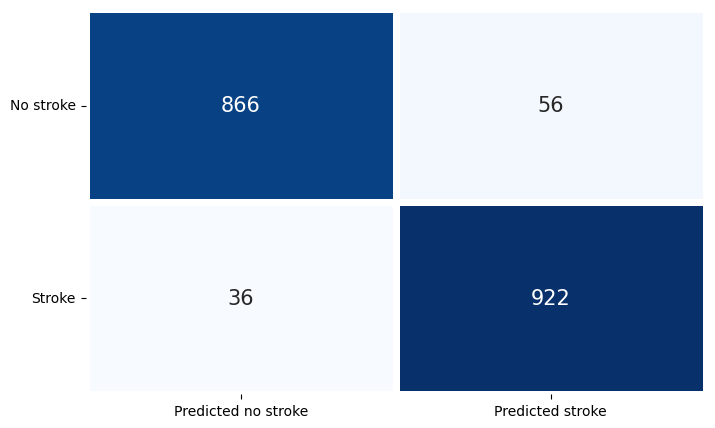

In [41]:
plt.figure(figsize = (8, 5))
sns.heatmap(xgb_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()


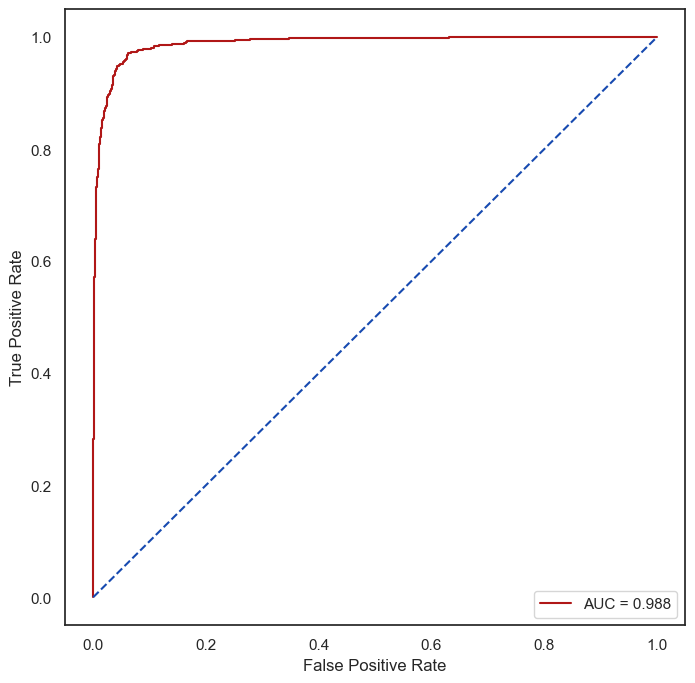

In [42]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
from sklearn import metrics
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [43]:
import pickle

pickle.dump(xgb, open("XGBstroke.pkl", "wb"))
loadxgbtrainedfile = pickle.load(open("XGBstroke.pkl", "rb"))
print(loadxgbtrainedfile)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


# Boosted RandomForest

In [44]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

xgb_rf = xgb.XGBClassifier(base_estimator=rf,n_estimators=10,learning_rate=0.1,booster='gbtree')



In [45]:
xgb_rf.fit(x_train_resampled, y_train_resampled)
y_pred = xgb_rf.predict(X_test)
y_prob = xgb_rf.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 2] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 2] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 2] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 2] = round(roc_auc_score(y_test, y_prob), 3)
xgb_rf_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')


              precision    recall  f1-score   support

           0       0.93      0.83      0.88       922
           1       0.85      0.94      0.89       958

    accuracy                           0.88      1880
   macro avg       0.89      0.88      0.88      1880
weighted avg       0.89      0.88      0.88      1880

ROC AUC score: 0.946


In [46]:
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(xgb_rf, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(xgb_rf, x_train_resampled, y_train_resampled, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(xgb_rf, x_train_resampled, y_train_resampled, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(xgb_rf, x_train_resampled, y_train_resampled, cv = 5, scoring = 'f1').mean(), 2)}")

results.iloc[4, 2] = round(cross_val_score(xgb_rf, x_train_resampled, y_train_resampled, cv = 5, scoring = 'roc_auc').mean(), 3)


Cross-validation scores with 5 folds:

ROC AUC: 0.929
precision: 0.82
recall: 0.93
f1: 0.87


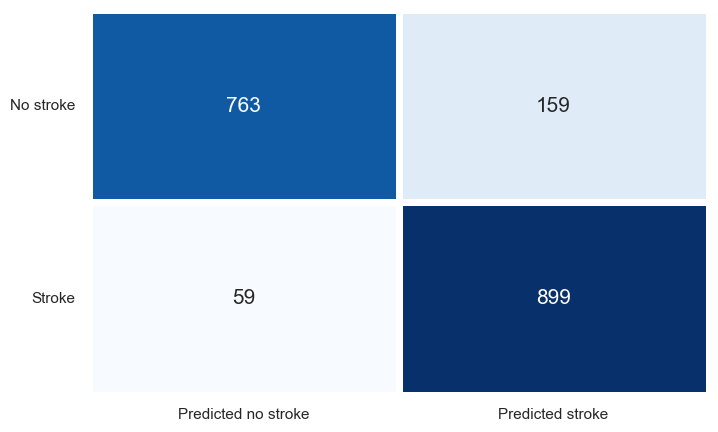

In [47]:
# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(xgb_rf_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()


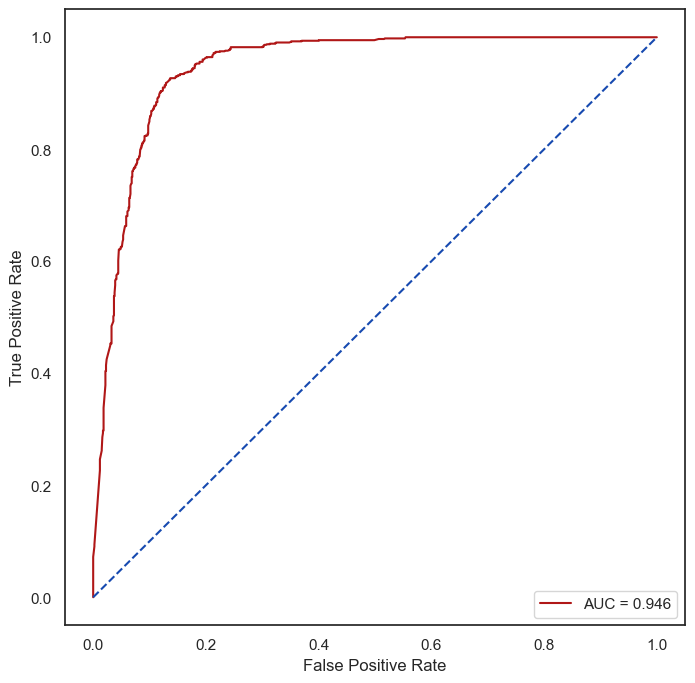

In [48]:
# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
from sklearn import metrics

roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

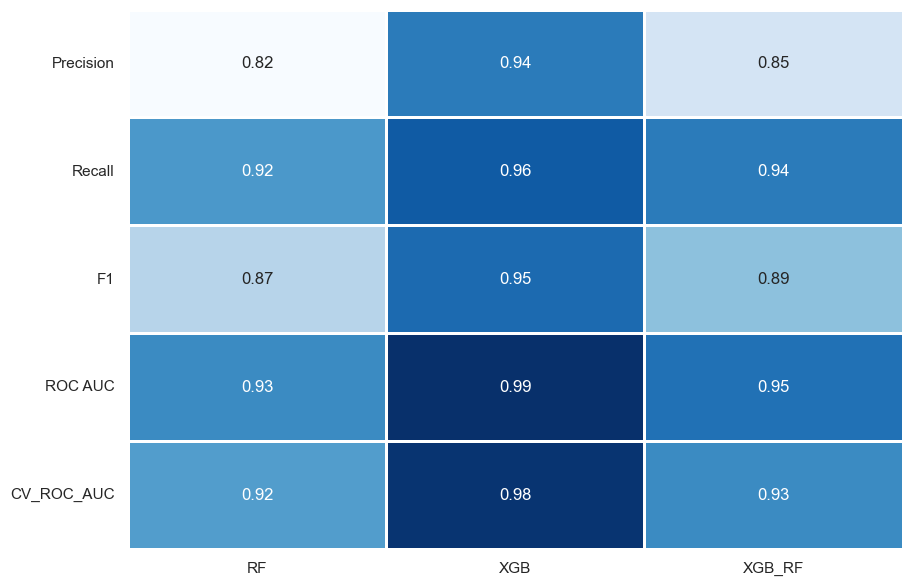

In [49]:
plt.figure(figsize = (10, 7))
sns.heatmap(results[results.columns.to_list()].astype(float), cmap = 'Blues', annot = True, linewidths = 1, cbar = False, annot_kws = {'fontsize': 12},
           yticklabels = ['Precision', 'Recall', 'F1', 'ROC AUC','CV_ROC_AUC'])
sns.set(font_scale = 1.5)
plt.yticks(rotation = 0)
plt.show()

In [50]:
pickle.dump(xgb_rf, open("XGB_RFstroke.pkl", "wb"))
loadxgbrftrainedfile = pickle.load(open("XGB_RFstroke.pkl", "rb"))
print(loadxgbrftrainedfile)

XGBClassifier(base_estimator=RandomForestClassifier(), base_score=None,
              booster='gbtree', callbacks=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, ...)
